In [21]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import numpy as np
import warnings

### Montar Dataframe

In [22]:
# Realizar conexão com o GCP
credentials = service_account.Credentials.from_service_account_file("../keys/ml-na-saude-ed1fc3c1a83e.json")
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

In [23]:
# Query para consulta dos dados agrupados por taxa média por quadrimestre
consulta_sql = """
select
	tx.quadrimestre,
	avg(tx.taxa_yll) as taxa_media_yll
from (
	with yll_quadrimestral as (
		select
			case
				when extract(month from y.dt_obito) between 1 and 4 then date(extract(year from y.dt_obito), 4, 30)
				when extract(month from y.dt_obito) between 5 and 8 then date(extract(year from y.dt_obito), 8, 31)
				when extract(month from y.dt_obito) between 9 and 12 then date(extract(year from y.dt_obito), 12, 31)
				end as quadrimestre,
			m.nm_municipio,
			p.populacao,
			sum(y.yll) as soma_yll
		from `ml-na-saude.yll_por_obito.yll` y
		join `ml-na-saude.yll_por_obito.populacao` p on y.cd_mun_res = p.cd_municipio and y.ano_obito = p.ano
		join `ml-na-saude.yll_por_obito.municipio` m on p.cd_municipio = m.cd_municipio
		where p.porte = 'Médio Porte'
		group by 1,2,3
	)
	select
		quadrimestre,
		nm_municipio,
		soma_yll,
		populacao,
		soma_yll / populacao * 1000 as taxa_yll
	from yll_quadrimestral
	group by 1,2,3,4
) tx
group by 1
order by 1
"""

In [24]:
# Ignorar avisos e gerar dataframe
warnings.simplefilter("ignore")
df = client.query(consulta_sql).to_dataframe()

In [25]:
# Copiar dataframe para manipular dados
time_series = df.copy()

In [26]:
# Transformar o quadrimestre em data
time_series['quadrimestre'] = pd.to_datetime(time_series['quadrimestre'])

In [27]:
# Filtrar dados até final de 2019
time_series = time_series[time_series['quadrimestre'] <= '2019-12-31']

In [28]:
time_series

,quadrimestre,taxa_media_yll
0,2010-04-30,6.427726
1,2010-08-31,6.767661
2,2010-12-31,6.111099
3,2011-04-30,6.550037
4,2011-08-31,6.878076
5,2011-12-31,5.804813
6,2012-04-30,6.280719
7,2012-08-31,6.739170
8,2012-12-31,6.049970
9,2013-04-30,6.253954


### Análise Exploratória

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
import scipy.stats as stats

In [30]:
from statsmodels.tsa.stattools import adfuller

# Executar o teste de Dickey-Fuller Aumentado (ADF)
yll_series = time_series['taxa_media_yll']
result = adfuller(yll_series)

# Criar um DataFrame para apresentar os resultados
adf_table = pd.DataFrame({
    "Estatística de Teste": [result[0]],
    "Valor-p": [result[1]],
    "Valor Crítico (1%)": [result[4]["1%"]],
    "Valor Crítico (5%)": [result[4]["5%"]],
    "Valor Crítico (10%)": [result[4]["10%"]]
})

# Exibir a tabela
adf_table

,Estatística de Teste,Valor-p,Valor Crítico (1%),Valor Crítico (5%),Valor Crítico (10%)
0,-2.343977,0.158176,-3.752928,-2.9985,-2.638967


In [31]:
# Configurações visuais
plt.rcParams['figure.figsize'] = [12, 8]

# 1. Estatísticas Descritivas Básicas
print("1. Estatísticas Descritivas da Taxa Média YLL:")
print(time_series['taxa_media_yll'].describe())
print("\nPeríodo da série:")
print(f"Início: {time_series['quadrimestre'].min()}")
print(f"Fim: {time_series['quadrimestre'].max()}")
print(f"Total de períodos: {len(time_series)}")

1. Estatísticas Descritivas da Taxa Média YLL:
count    30.000000
mean      6.327479
std       0.468342
min       5.571991
25%       5.952523
50%       6.274600
75%       6.735427
max       7.221472
Name: taxa_media_yll, dtype: float64

Período da série:
Início: 2010-04-30 00:00:00
Fim: 2019-12-31 00:00:00
Total de períodos: 30


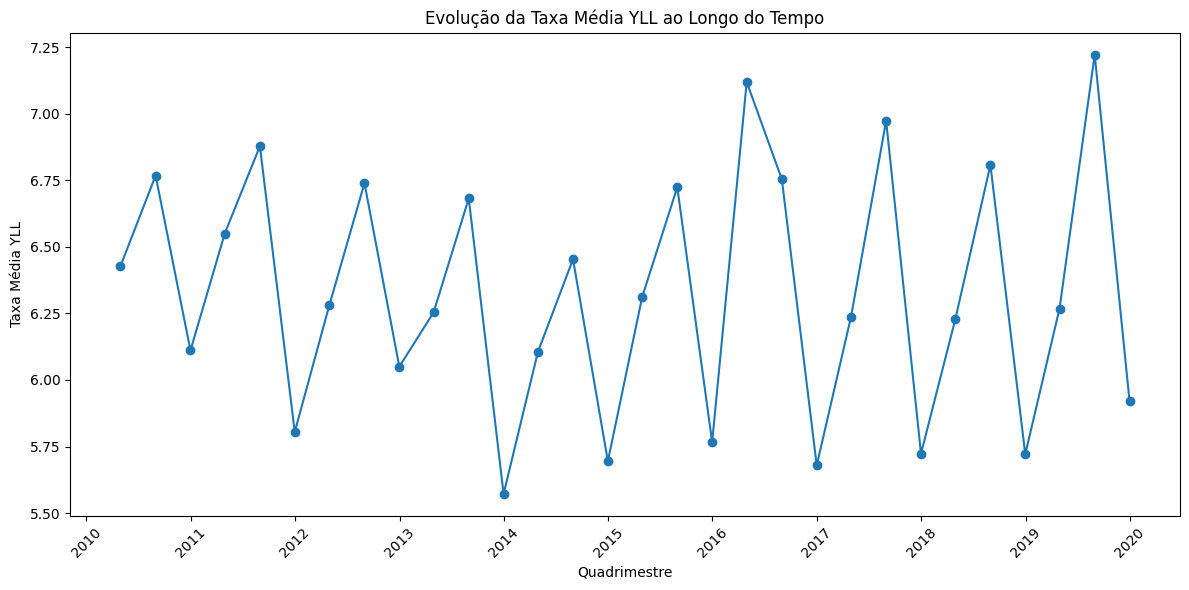

In [32]:
# 2. Visualização da Série Temporal
plt.figure(figsize=(12, 6))
plt.plot(time_series['quadrimestre'], time_series['taxa_media_yll'], marker='o')
plt.title('Evolução da Taxa Média YLL ao Longo do Tempo')
plt.xlabel('Quadrimestre')
plt.ylabel('Taxa Média YLL')
# plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

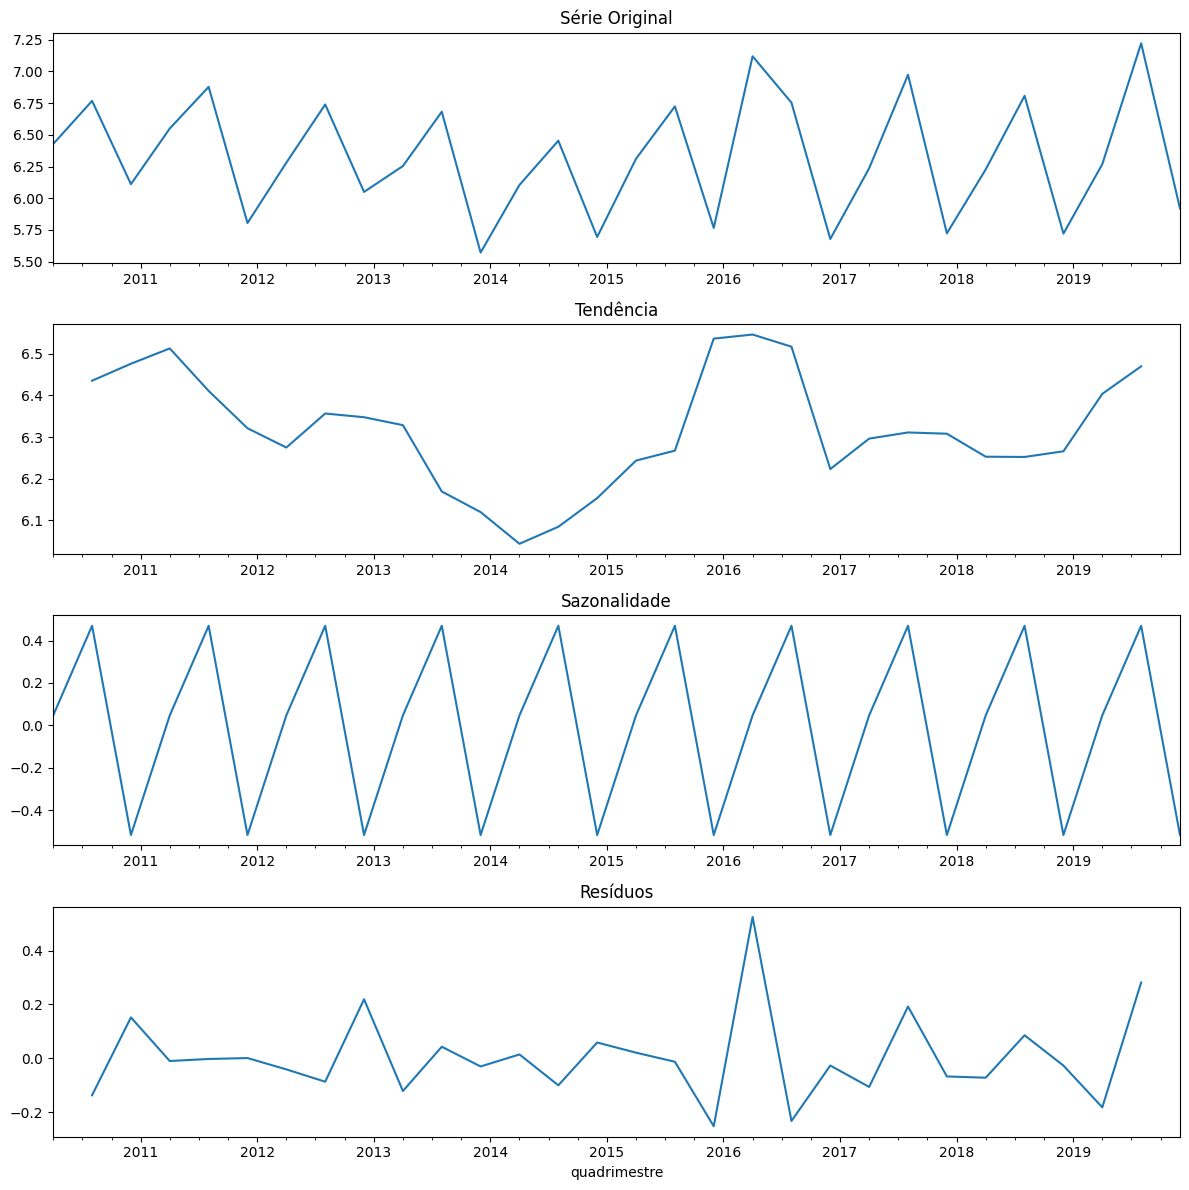

In [33]:
# 3. Decomposição da Série Temporal
# Definir o índice como data para usar o seasonal_decompose
ts = time_series.set_index('quadrimestre')['taxa_media_yll']

# Realizar decomposição
decomposicao = seasonal_decompose(ts, period=3)  # period=3 para dados quadrimestrais

# Plotar decomposição
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12))

decomposicao.observed.plot(ax=ax1)
ax1.set_title('Série Original')
ax1.set_xlabel('')

decomposicao.trend.plot(ax=ax2)
ax2.set_title('Tendência')
ax2.set_xlabel('')

decomposicao.seasonal.plot(ax=ax3)
ax3.set_title('Sazonalidade')
ax3.set_xlabel('')

decomposicao.resid.plot(ax=ax4)
ax4.set_title('Resíduos')

plt.tight_layout()
plt.show()

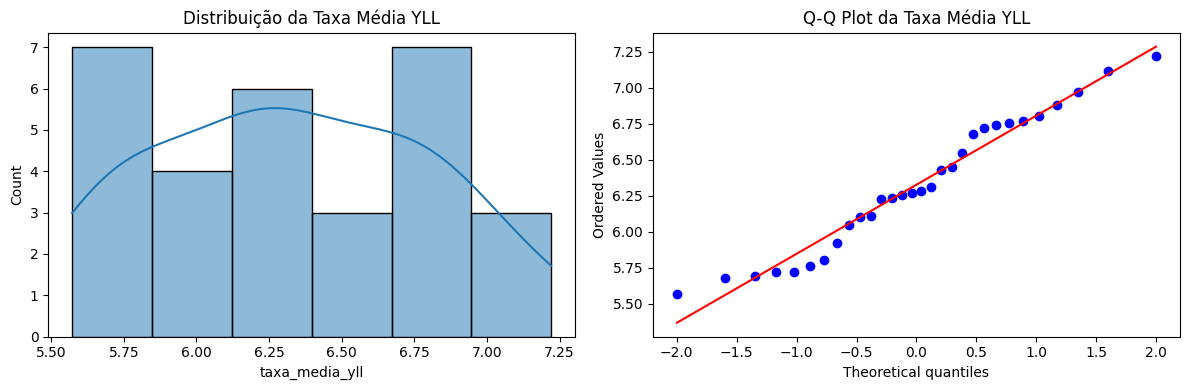

In [34]:
# 4. Análise de Distribuição
plt.figure(figsize=(12, 4))

# Histograma
plt.subplot(121)
sns.histplot(data=time_series, x='taxa_media_yll', kde=True)
plt.title('Distribuição da Taxa Média YLL')

# QQ Plot
plt.subplot(122)
stats.probplot(time_series['taxa_media_yll'], dist="norm", plot=plt)
plt.title('Q-Q Plot da Taxa Média YLL')

plt.tight_layout()
plt.show()

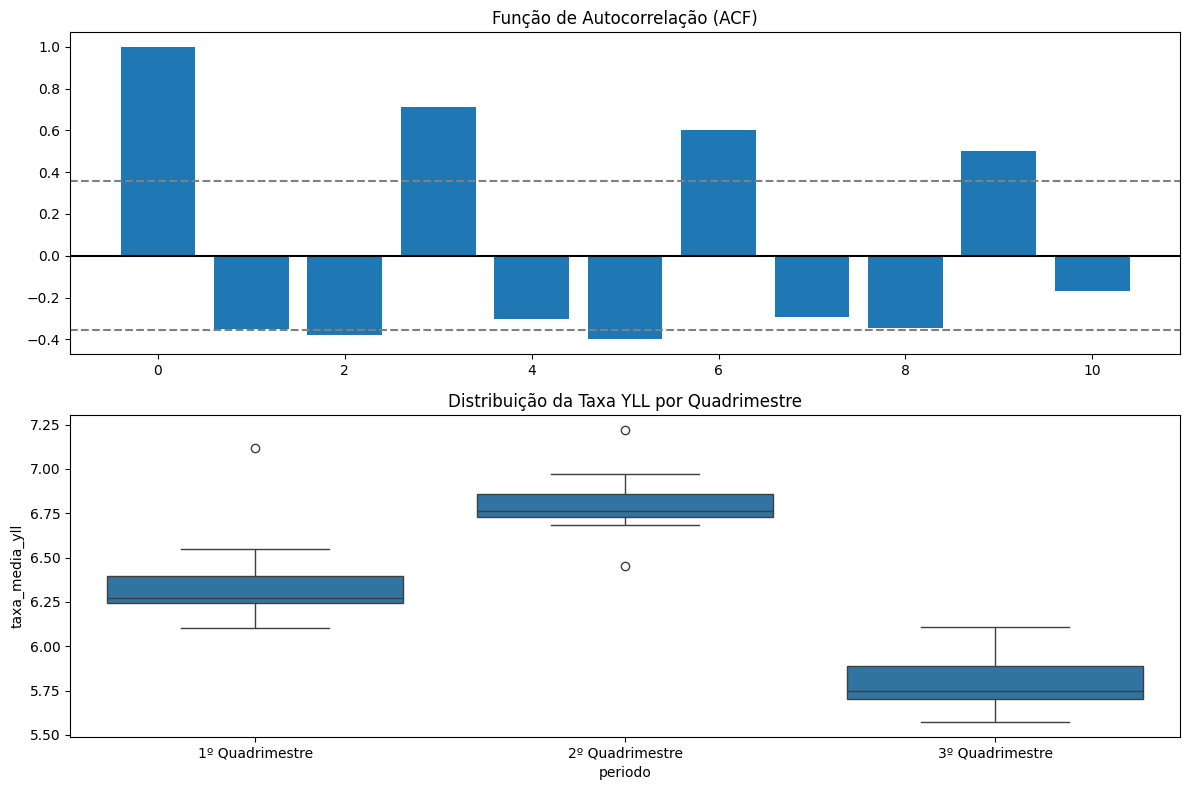

In [35]:
# 5. Análise de Autocorrelação
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF
acf_values = acf(time_series['taxa_media_yll'], nlags=10)
ax1.bar(range(len(acf_values)), acf_values)
ax1.axhline(y=0, linestyle='-', color='black')
ax1.axhline(y=-1.96/np.sqrt(len(time_series)), linestyle='--', color='gray')
ax1.axhline(y=1.96/np.sqrt(len(time_series)), linestyle='--', color='gray')
ax1.set_title('Função de Autocorrelação (ACF)')

# Box plot por período do ano
time_series['periodo'] = time_series['quadrimestre'].dt.month.map({
    4: '1º Quadrimestre',
    8: '2º Quadrimestre',
    12: '3º Quadrimestre'
})
sns.boxplot(data=time_series, x='periodo', y='taxa_media_yll', ax=ax2)
ax2.set_title('Distribuição da Taxa YLL por Quadrimestre')

plt.tight_layout()
plt.show()

In [36]:
# 6. Estatísticas por período

# Definindo opções para exibir todas as colunas no output
pd.options.display.max_columns = None  # Mostra todas as colunas
pd.options.display.expand_frame_repr = False  # Evita que o dataframe quebre linhas

print("\nEstatísticas por Quadrimestre:")
print(time_series.groupby('periodo')['taxa_media_yll'].describe())


Estatísticas por Quadrimestre:
                 count      mean       std       min       25%       50%       75%       max
periodo                                                                                     
1º Quadrimestre   10.0  6.378098  0.286707  6.104961  6.241056  6.274600  6.398675  7.119191
2º Quadrimestre   10.0  6.800061  0.200106  6.453612  6.727943  6.760642  6.860446  7.221472
3º Quadrimestre   10.0  5.804277  0.171409  5.571991  5.701426  5.744885  5.891234  6.111099


In [37]:
# 7. Análise de Variação
time_series['variacao'] = time_series['taxa_media_yll'].pct_change() * 100

print("\nEstatísticas das Variações Percentuais:")
print(time_series['variacao'].describe())


Estatísticas das Variações Percentuais:
count    29.000000
mean      0.438676
std      12.063170
min     -18.021700
25%     -11.758477
50%       5.710944
75%       9.312114
max      23.457173
Name: variacao, dtype: float64


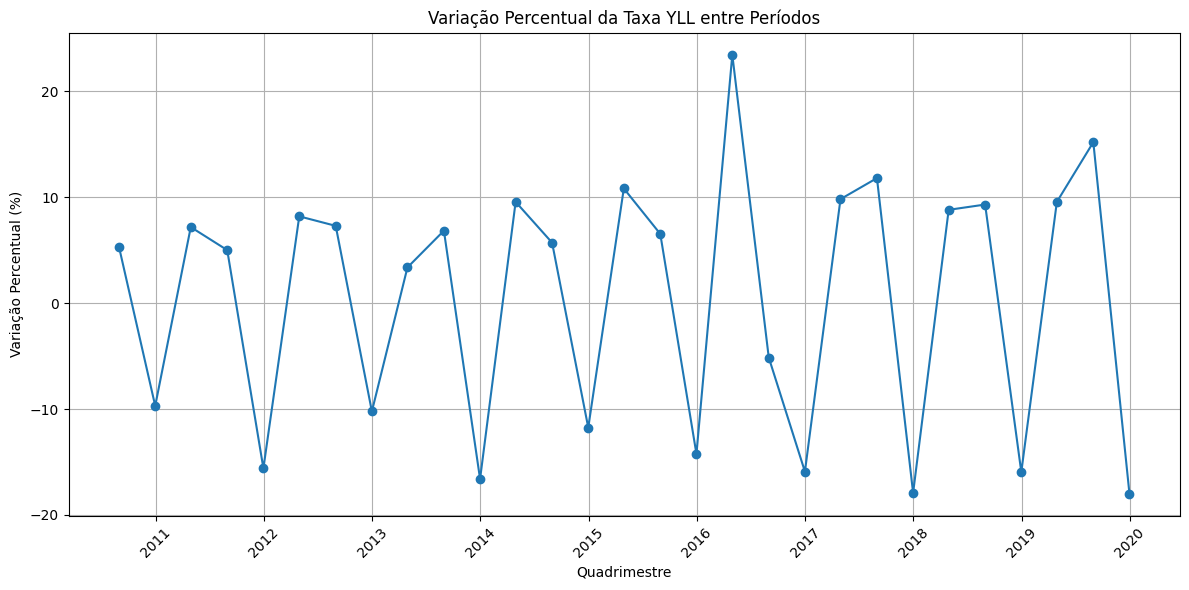

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(time_series['quadrimestre'], time_series['variacao'], marker='o')
plt.title('Variação Percentual da Taxa YLL entre Períodos')
plt.xlabel('Quadrimestre')
plt.ylabel('Variação Percentual (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Código Único

1. Estatísticas Descritivas da Taxa Média YLL:
count    30.000000
mean      6.327479
std       0.468342
min       5.571991
25%       5.952523
50%       6.274600
75%       6.735427
max       7.221472
Name: taxa_media_yll, dtype: float64

Período da série:
Início: 2010-04-30 00:00:00
Fim: 2019-12-31 00:00:00
Total de períodos: 30


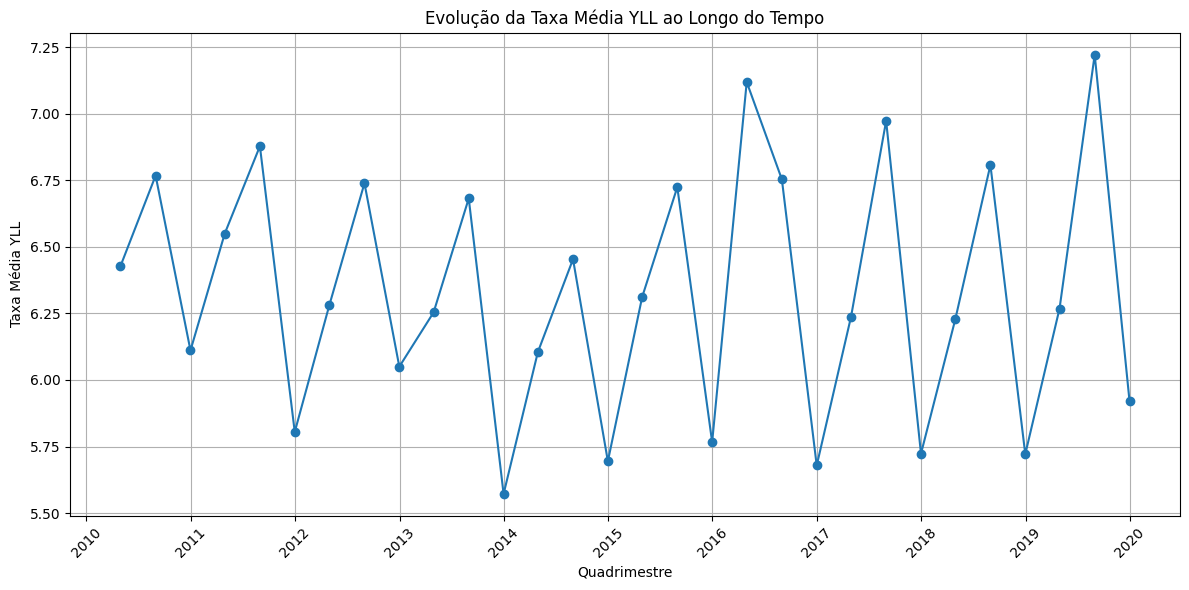

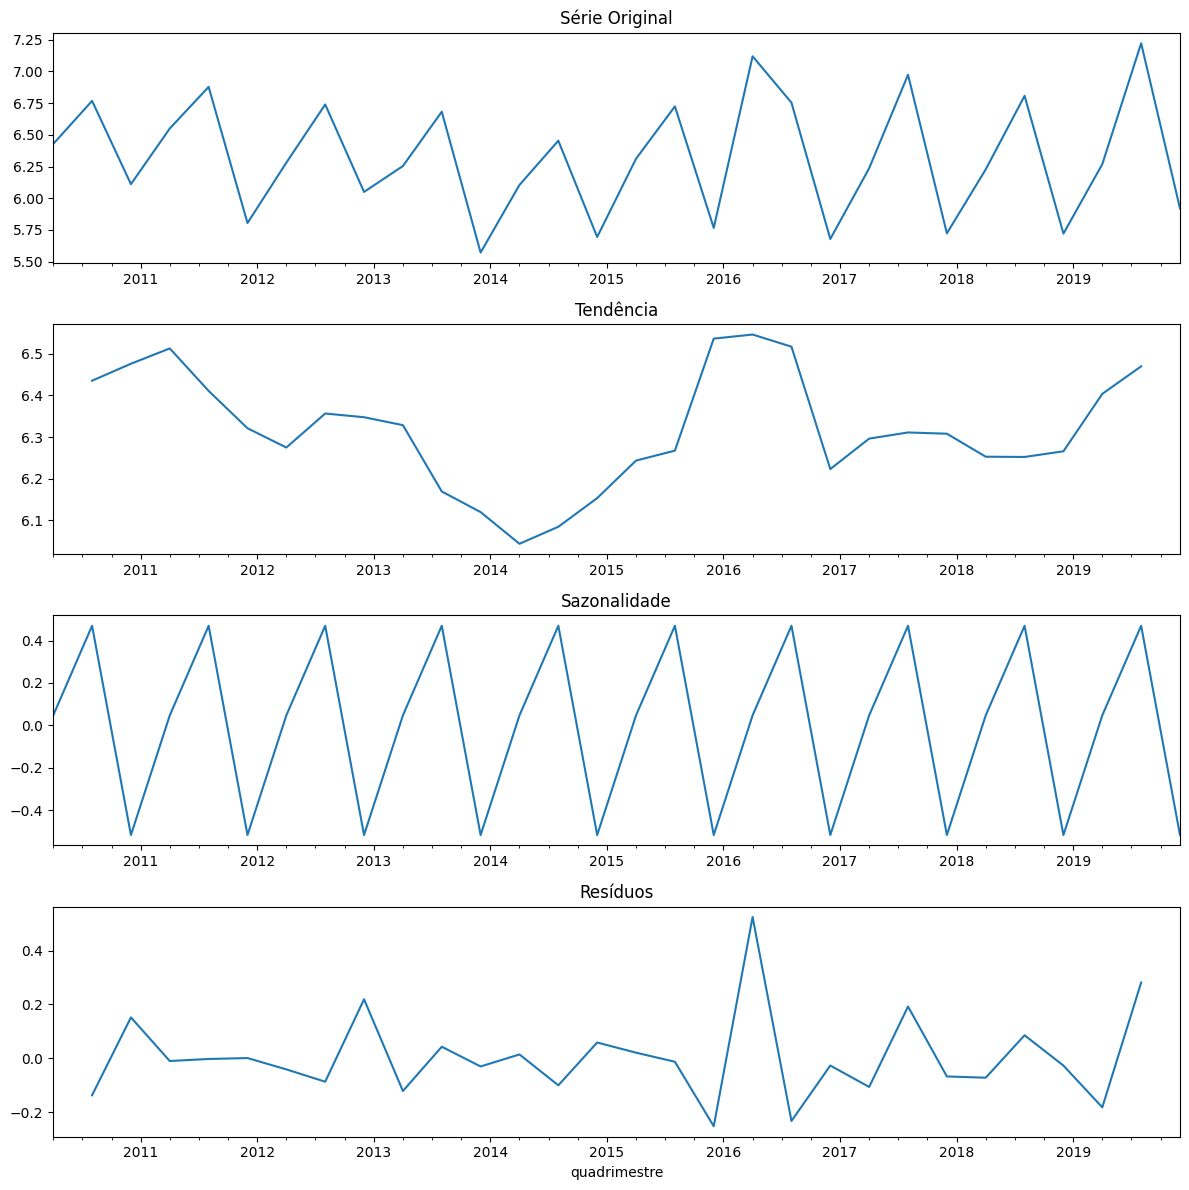

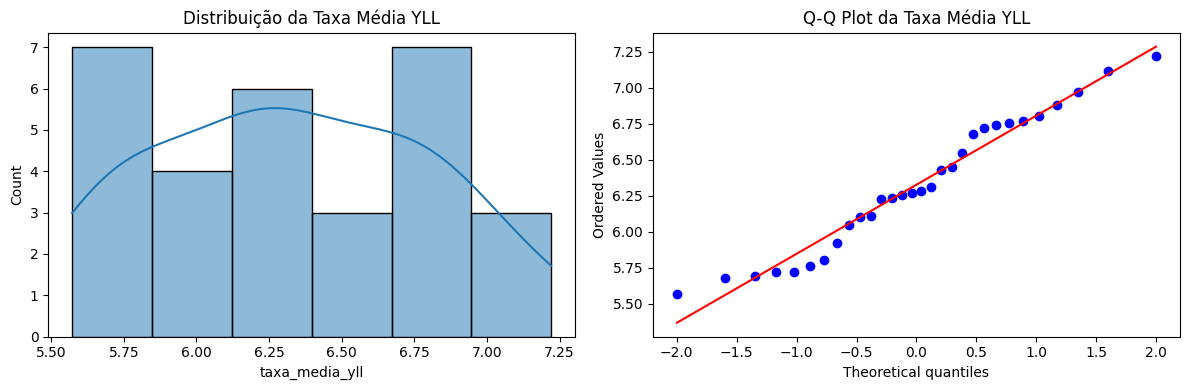

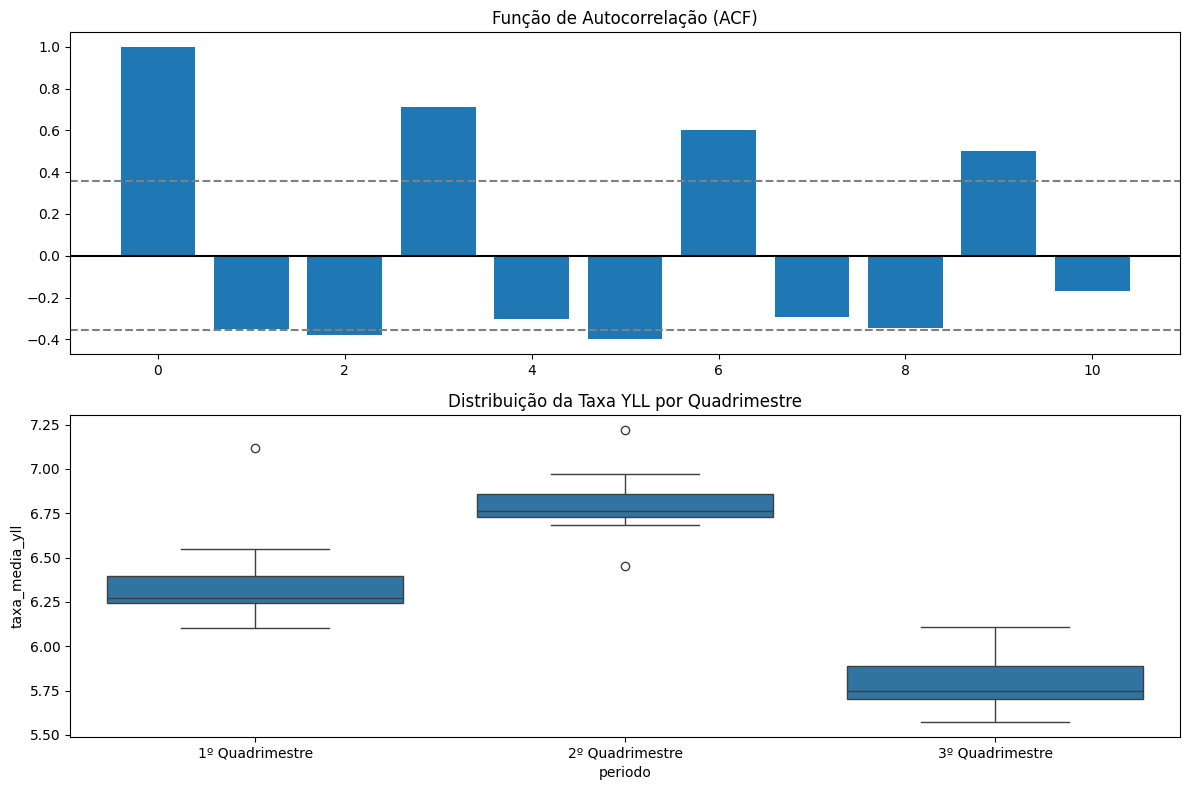


Estatísticas por Quadrimestre:
                 count      mean       std       min       25%       50%       75%       max
periodo                                                                                     
1º Quadrimestre   10.0  6.378098  0.286707  6.104961  6.241056  6.274600  6.398675  7.119191
2º Quadrimestre   10.0  6.800061  0.200106  6.453612  6.727943  6.760642  6.860446  7.221472
3º Quadrimestre   10.0  5.804277  0.171409  5.571991  5.701426  5.744885  5.891234  6.111099

Estatísticas das Variações Percentuais:
count    29.000000
mean      0.438676
std      12.063170
min     -18.021700
25%     -11.758477
50%       5.710944
75%       9.312114
max      23.457173
Name: variacao, dtype: float64


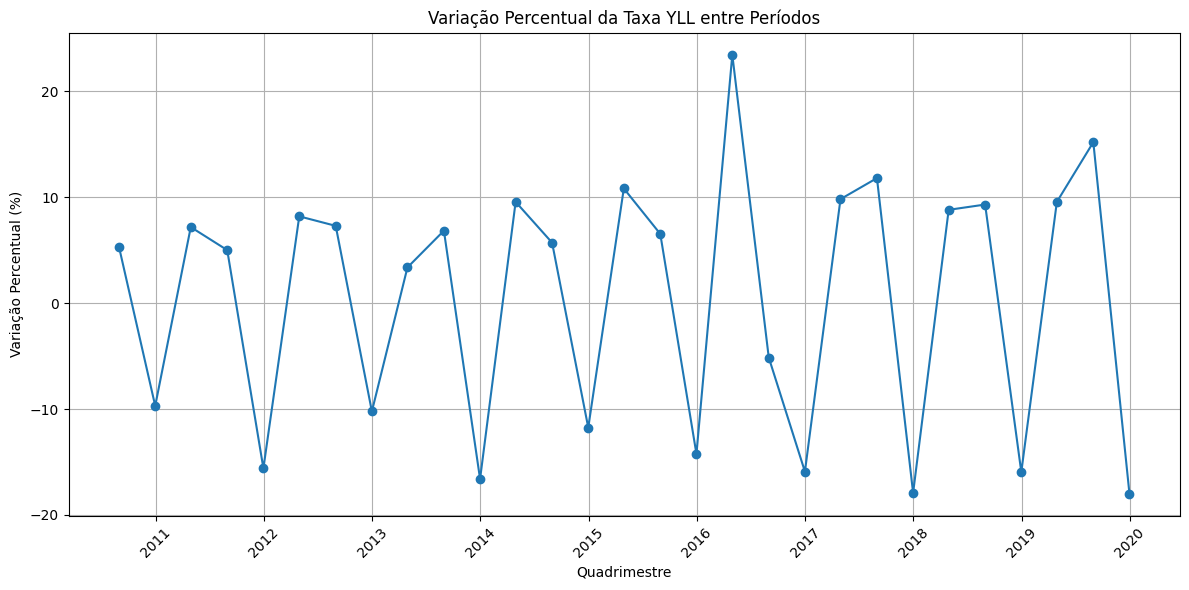

In [ ]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
import scipy.stats as stats

# Realizar conexão com o GCP
credentials = service_account.Credentials.from_service_account_file("../keys/ml-na-saude-ed1fc3c1a83e.json")
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# Query para consulta dos dados agrupados por taxa média por quadrimestre
consulta_sql = """
select
	tx.quadrimestre,
	avg(tx.taxa_yll) as taxa_media_yll
from (
	with yll_quadrimestral as (
		select
			case
				when extract(month from y.dt_obito) between 1 and 4 then date(extract(year from y.dt_obito), 4, 30)
				when extract(month from y.dt_obito) between 5 and 8 then date(extract(year from y.dt_obito), 8, 31)
				when extract(month from y.dt_obito) between 9 and 12 then date(extract(year from y.dt_obito), 12, 31)
				end as quadrimestre,
			m.nm_municipio,
			p.populacao,
			sum(y.yll) as soma_yll
		from `ml-na-saude.yll_por_obito.yll` y
		join `ml-na-saude.yll_por_obito.populacao` p on y.cd_mun_res = p.cd_municipio and y.ano_obito = p.ano
		join `ml-na-saude.yll_por_obito.municipio` m on p.cd_municipio = m.cd_municipio
		where p.porte = 'Médio Porte'
		group by 1,2,3
	)
	select
		quadrimestre,
		nm_municipio,
		soma_yll,
		populacao,
		soma_yll / populacao * 1000 as taxa_yll
	from yll_quadrimestral
	group by 1,2,3,4
) tx
group by 1
order by 1
"""

# Ignorar avisos e gerar dataframe
warnings.simplefilter("ignore")
df = client.query(consulta_sql).to_dataframe()
# Copiar dataframe para manipular dados
time_series = df.copy()
# Transformar o quadrimestre em data
time_series['quadrimestre'] = pd.to_datetime(time_series['quadrimestre'])
# Filtrar dados até final de 2019
time_series = time_series[time_series['quadrimestre'] <= '2019-12-31']

def analise_exploratoria_temporal(time_series):
    """
    Realiza uma análise exploratória completa de uma série temporal
    
    Parâmetros:
    time_series: DataFrame com colunas 'quadrimestre' e 'taxa_media_yll'
    """
    
    # Configurações visuais
    plt.rcParams['figure.figsize'] = [12, 8]
    
    # 1. Estatísticas Descritivas Básicas
    print("1. Estatísticas Descritivas da Taxa Média YLL:")
    print(time_series['taxa_media_yll'].describe())
    print("\nPeríodo da série:")
    print(f"Início: {time_series['quadrimestre'].min()}")
    print(f"Fim: {time_series['quadrimestre'].max()}")
    print(f"Total de períodos: {len(time_series)}")
    
    # 2. Visualização da Série Temporal
    plt.figure(figsize=(12, 6))
    plt.plot(time_series['quadrimestre'], time_series['taxa_media_yll'], marker='o')
    plt.title('Evolução da Taxa Média YLL ao Longo do Tempo')
    plt.xlabel('Quadrimestre')
    plt.ylabel('Taxa Média YLL')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 3. Decomposição da Série Temporal
    # Definir o índice como data para usar o seasonal_decompose
    ts = time_series.set_index('quadrimestre')['taxa_media_yll']
    
    # Realizar decomposição
    decomposicao = seasonal_decompose(ts, period=3)  # period=3 para dados quadrimestrais
    
    # Plotar decomposição
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12))
    
    decomposicao.observed.plot(ax=ax1)
    ax1.set_title('Série Original')
    ax1.set_xlabel('')
    
    decomposicao.trend.plot(ax=ax2)
    ax2.set_title('Tendência')
    ax2.set_xlabel('')
    
    decomposicao.seasonal.plot(ax=ax3)
    ax3.set_title('Sazonalidade')
    ax3.set_xlabel('')
    
    decomposicao.resid.plot(ax=ax4)
    ax4.set_title('Resíduos')
    
    plt.tight_layout()
    plt.show()
    
    # 4. Análise de Distribuição
    plt.figure(figsize=(12, 4))
    
    # Histograma
    plt.subplot(121)
    sns.histplot(data=time_series, x='taxa_media_yll', kde=True)
    plt.title('Distribuição da Taxa Média YLL')
    
    # QQ Plot
    plt.subplot(122)
    stats.probplot(time_series['taxa_media_yll'], dist="norm", plot=plt)
    plt.title('Q-Q Plot da Taxa Média YLL')
    
    plt.tight_layout()
    plt.show()
    
    # 5. Análise de Autocorrelação
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # ACF
    acf_values = acf(time_series['taxa_media_yll'], nlags=10)
    ax1.bar(range(len(acf_values)), acf_values)
    ax1.axhline(y=0, linestyle='-', color='black')
    ax1.axhline(y=-1.96/np.sqrt(len(time_series)), linestyle='--', color='gray')
    ax1.axhline(y=1.96/np.sqrt(len(time_series)), linestyle='--', color='gray')
    ax1.set_title('Função de Autocorrelação (ACF)')
    
    # Box plot por período do ano
    time_series['periodo'] = time_series['quadrimestre'].dt.month.map({
        4: '1º Quadrimestre',
        8: '2º Quadrimestre',
        12: '3º Quadrimestre'
    })
    sns.boxplot(data=time_series, x='periodo', y='taxa_media_yll', ax=ax2)
    ax2.set_title('Distribuição da Taxa YLL por Quadrimestre')
    
    plt.tight_layout()
    plt.show()
    
    # 6. Estatísticas por período
    print("\nEstatísticas por Quadrimestre:")
    print(time_series.groupby('periodo')['taxa_media_yll'].describe())
    
    # 7. Análise de Variação
    time_series['variacao'] = time_series['taxa_media_yll'].pct_change() * 100
    
    print("\nEstatísticas das Variações Percentuais:")
    print(time_series['variacao'].describe())
    
    plt.figure(figsize=(12, 6))
    plt.plot(time_series['quadrimestre'], time_series['variacao'], marker='o')
    plt.title('Variação Percentual da Taxa YLL entre Períodos')
    plt.xlabel('Quadrimestre')
    plt.ylabel('Variação Percentual (%)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Executar a análise
analise_exploratoria_temporal(time_series)